# GPU Version to run on MARCC

This notebook is assummed to be launched from the top level of the AutomaticLP github repo (where the notebook file is)

This also assummes that you've already cloed the tensorflow object detection project
https://github.com/tensorflow/models (since you need to do this to add the python path to  the bashrc file which has to be done before launching jupyter lab

Run with the LPproject kernel

## Setup / Installations

Add
<code>
export PYTHONPATH=$PYTHONPATH:`pwd`
export PYTHONPATH=$PYTHONPATH:`pwd`/slim

to your ~/.bashrc file where pwd is the full path to the models/research directory

### Tests that Tensorflow GPU is installed & this notebook can see the GPU 

These don't need to be run everytime but are here as a sanity / debugging check

In [1]:
# test that tensorflow can access a GPU
import tensorflow as tf
tf.test.is_built_with_cuda()

True

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7710612676275185137
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8925461647664607157
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11329617920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9921250646624444714
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12711171375488494862
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
print ('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


Default GPU Device: /device:GPU:0


In [4]:
%%bash 
cd models/research
FILE=protobuf.zip
if [ ! -f "$FILE" ]; then
    wget -O protobuf.zip https://github.com/google/protobuf/releases/download/v3.0.0/protoc-3.0.0-linux-x86_64.zip
    unzip protobuf.zip
fi
./bin/protoc object_detection/protos/*.proto --python_out=.
pip install --user .

Processing /home-net/home-1/cpaolic1@jhu.edu/code/AutomaticLP/models/research
  Stored in directory: /tmp/pip-ephem-wheel-cache-emyhnsgg/wheels/ce/86/0c/1a704f75667a2580a756b306611e0a697afafce50c023988d0
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [5]:
!ml cuda/9.0
!export CUDA_VISIBLE_DEVICES=1
!echo ${CUDA_VISIBLE_DEVICES}

0


## Generating Datasets

The ScriptForBashFile generates both the training and test data and TFRecords from the image files

(For now hard coded to 100 images - TODO: switch back to user input, note then this won't be able to run with a bash script)

In [6]:
%run ScriptForBashFile

TrainingImages_2020-03-22_10-03
60  Training Images Generated
TestImages_2020-03-22_10-03
40  Test Images Generated



## Train


In [1]:
# If training output directory dosen't exist create it
!mkdir -p trainingOutput

In [12]:
# This makes the output of the next cell write to the file
# https://stackoverflow.com/questions/45200375/stdout-redirect-from-jupyter-notebook-is-landing-in-the-terminal
import sys
old_stdout = sys.stdout
sys.stdout = open('trainingLog.txt', 'w')

In [6]:
%cd models/research
!python object_detection/legacy/train.py --logtostderr --train_dir=../../trainingOutput/ --pipeline_config_path=../../FromScratch/models/model/ssd_mobilenet_v1_coco.config 
%cd ../..

/home/christina/Documents/Thesis/AutomaticLP/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Instructions for updating:
Use object_detection/model_main.py.
W0403 11:13:33.402055 140072907491008 deprecation.py:323] From /usr/lib/python3.7/site-packages/absl/app.py:250: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.

W0403 11:13:33.402284 140072907491008 module_wrapper.py:139] From object_detection/legacy/train.py:91: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0403 11:13:33.402642 140072907491008 module_wrapper.py:139] From /h

In [34]:
# Put the cell output back to normal
sys.stdout = old_stdout

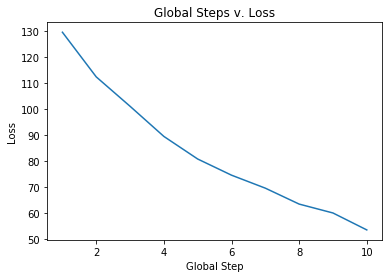

<Figure size 432x288 with 0 Axes>

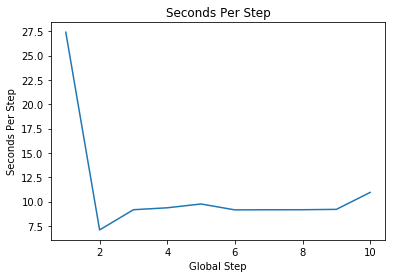

In [15]:
%matplotlib inline
%run viewTraining.py

## Evaluation

Both Evaluation and Training outputs can be looked at in Tensorboard for extra details

**TODO: update checkpoint number based on number of steps trained to** 

In [17]:
%cd models/research
!python object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path ../../FromScratch/models/model/ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix ../../trainingOutput/model.ckpt-10 --output_directory ../../inference_graph
%cd ../..

Enter Test Image Directory Name:  TestImages_2020-03-29_15-29
Enter Threshold (0-1) for object detection:  .8


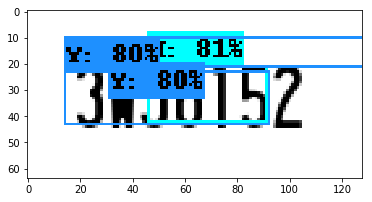

Show another image (y/n)?  y


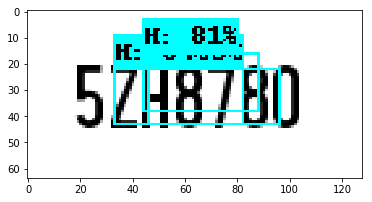

Show another image (y/n)?  y


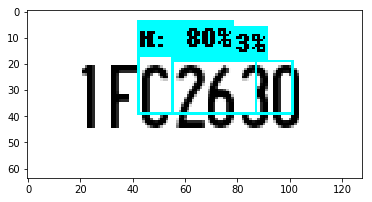

Show another image (y/n)?  n


In [30]:
%matplotlib inline
%run customEvaluation.py

In [7]:
%cd models/research
!python object_detection/legacy/eval.py --logtostderr --pipeline_config_path=../../FromScratch/models/model/ssd_mobilenet_v1_coco.config --checkpoint_dir=../../trainingOutput --eval_dir=../../evalOutput
%cd ../..

/home/christina/Documents/Thesis/AutomaticLP/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

2020-04-03 11:15:14.723042: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-04-03 11:15:14.723491: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2020-04-03 11:15:14.723533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marvin-computer): /proc/driver/nvidia/version does not exist
2020-04-03 11:15:14.7238